**Table of contents**<a id='toc0_'></a>    
- 1. [学习笔记概要](#toc1_)    
- 2. [深度神经网络](#toc2_)    
  - 2.1. [神经网络搭建八股-模块化设计](#toc2_1_)    
    - 2.1.1. [基本框架](#toc2_1_1_)    
      - 2.1.1.1. [forward.py](#toc2_1_1_1_)    
      - 2.1.1.2. [backword.py](#toc2_1_1_2_)    
      - 2.1.1.3. [predicted](#toc2_1_1_3_)    
    - 2.1.2. [断点续训](#toc2_1_2_)    
    - 2.1.3. [Keras API](#toc2_1_3_)    
    - 2.1.4. [Class 自定义](#toc2_1_4_)    
    - 2.1.5. [专题-损失函数](#toc2_1_5_)    
      - 2.1.5.1. [均绝对值误差-l1 loss](#toc2_1_5_1_)    
      - 2.1.5.2. [均方误差-l2 loss](#toc2_1_5_2_)    
      - 2.1.5.3. [交叉熵](#toc2_1_5_3_)    
      - 2.1.5.4. [自定义](#toc2_1_5_4_)    
    - 2.1.6. [专题-优化器](#toc2_1_6_)    
      - 2.1.6.1. [梯度下降](#toc2_1_6_1_)    
      - 2.1.6.2. [adagrad](#toc2_1_6_2_)    
      - 2.1.6.3. [RMSProp](#toc2_1_6_3_)    
- 3. [卷积神经网络-CNN](#toc3_)    
  - 3.1. [LeNet5](#toc3_1_)    
- 4. [循环神经网络-RNN](#toc4_)    
  - 4.1. [LSTM](#toc4_1_)    
  - 4.2. [Transform](#toc4_2_)    
- 5. [注意力机制](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[学习笔记概要](#toc0_)
```
《动手学习深度学习》：
    Python机器学习-第二版书籍
    动手学深度学习-第二版书籍：http://zh.d2l.ai/chapter_preface/index.html
    动手学深度学习-B站视频：https://space.bilibili.com/1567748478/channel/seriesdetail?sid=358497
    Tensorflow1.3-B站视频：https://www.bilibili.com/video/BV1m7411d7kT/?spm_id_from=333.999.0.0
    Tensorflow2.0-B站视频：https://www.bilibili.com/video/BV1B7411L7Qt/?vd_source=9711437953435a0b7620eae6546ad6cf
1. 视频里都是用的Pytorch进行演算，我通过学习北京大学曹建老师的Tensorflow教程复现其中代码部分，加深对Tensorflow和深度神经网络理解。
2. 会调用代码完成任务是一回事，学习代码是另一回事，不一定等好的。 - 李沐
3. 构建只是体系，点连接成线，线连接成面，关键基础知识点夯实举一反三的学习拓展或延申的新知识。 - 李沐
```

# 2. <a id='toc2_'></a>[深度神经网络](#toc0_)

## 2.1. <a id='toc2_1_'></a>[神经网络搭建八股-模块化设计](#toc0_)

In [2]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

minist = input_data.read_data_sets('./minist_data', one_hot=True)
minist

ModuleNotFoundError: No module named 'tensorflow.examples'

### 2.1.1. <a id='toc2_1_1_'></a>[基本框架](#toc0_)
#### 2.1.1.1. <a id='toc2_1_1_1_'></a>[forward.py](#toc0_)
```
1. 构建网络，
2. 初始权重，
3. 并符号计算
```

In [5]:
import tensorflow as tf 

def get_weights(shape, REGULARIZER):
    w = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    if REGULARIZER != None:
        tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(REGULARIZER)(w)) # 添加正则化
    return w

def get_bias(shape):
    '''bias 不进行正则化'''
    b = tf.Variable(tf.zeros(shape=shape))
    return b

def forward(x, REGULARIZER): # 数据的前向传播
    '''
    搭建网络，设计网络结构
    按照计算步骤，从神经网络的各层依次进行计算（传播）
    '''
    # 隐藏层
    n_hidden = 100
    w_h = get_weights(shape=[784, n_hidden], REGULARIZER=REGULARIZER)
    b_h = get_bias(n_hidden)
    a_h = tf.nn.relu(tf.matmul(x, w_h) + b_h)
    # 输出层
    n_out = 10
    w_o = get_weights(shape=[n_hidden, n_out], REGULARIZER=REGULARIZER)
    b_o = get_bias(n_out)
    z_o = tf.matmul(a_h, w_o) + b_o # 输出层不过激活函数
    return z_o

#### 2.1.1.2. <a id='toc2_1_1_2_'></a>[backword.py](#toc0_)
```
1. 计算误差（loss function)
2. 优化：求梯度并更新权重w和b
```

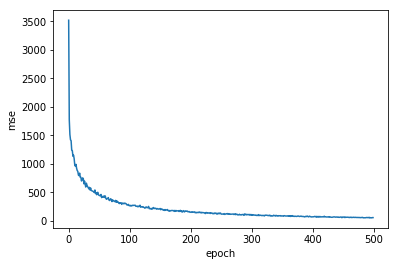

In [7]:
def backpropagate(): # 误差的反向传播
    '''
    训练网络，优化网络参数
    反向求导，进行误差的反向传播
    '''
    # REGULARIZER = None # 先不正则化看看
    REGULARIZER = 0.01
    BATCH_SIZE= 200 # 每次提交的批量样本量
    EPOCHS = 500 # 迭代数

    ############
    # 前向计算
    x = tf.placeholder(tf.float32, shape=(None, 784)) # 自变量x
    y = tf.placeholder(tf.float32, shape=(None, 10)) # 真实y值
    y_hat = forward(x, REGULARIZER) # 计算的y值

    ############
    # loss function
    mse = tf.reduce_mean(tf.square(y_hat - y)) # 定义损失函数: 1. 均方误差-MSE 2. 自定义 3. 交叉熵
    # mse_regul = mse + tf.add_n(tf.get_collection('losses')) # 正则化

    ############
    # opt优化并更新w和b
    train_step = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss=mse)

    saver = tf.train.Saver(train_step)

    ############
    # 开始会话，计算图
    with tf.Session() as sess:
        # 初始化所有变量
        init = tf.global_variables_initializer()
        sess.run(init)
        
        cost_list = []  
        for i in range(EPOCHS):
            xs, ys = minist.train.next_batch(BATCH_SIZE)
            cost, _ = sess.run([mse, train_step], {x:xs, y:ys}) # 返回值
            cost_list.append(cost)
            # if not i % 1000:
            #     print(f"{i}) cost: {cost}")
    return cost_list

if __name__ == "__main__":
    # backpropagate()
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(backpropagate())
    plt.xlabel('epoch')
    plt.ylabel('mse')

#### 2.1.1.3. <a id='toc2_1_1_3_'></a>[predicted](#toc0_)

### 2.1.2. <a id='toc2_1_2_'></a>[断点续训](#toc0_)

### 2.1.3. <a id='toc2_1_3_'></a>[Keras API](#toc0_)

### 2.1.4. <a id='toc2_1_4_'></a>[Class 自定义](#toc0_)

### 2.1.5. <a id='toc2_1_5_'></a>[专题-损失函数](#toc0_)
#### 2.1.5.1. <a id='toc2_1_5_1_'></a>[均绝对值误差-l1 loss](#toc0_)

#### 2.1.5.2. <a id='toc2_1_5_2_'></a>[均方误差-l2 loss](#toc0_)

#### 2.1.5.3. <a id='toc2_1_5_3_'></a>[交叉熵](#toc0_)

#### 2.1.5.4. <a id='toc2_1_5_4_'></a>[自定义](#toc0_)

### 2.1.6. <a id='toc2_1_6_'></a>[专题-优化器](#toc0_)

#### 2.1.6.1. <a id='toc2_1_6_1_'></a>[梯度下降](#toc0_)

#### 2.1.6.2. <a id='toc2_1_6_2_'></a>[adagrad](#toc0_)

#### 2.1.6.3. <a id='toc2_1_6_3_'></a>[RMSProp](#toc0_)

# 3. <a id='toc3_'></a>[卷积神经网络-CNN](#toc0_)
```
CBAPD: 卷积，批量归一化，激活，池化，丢弃
卷积层就是特征提取，随后将特征传入FC（全连接层）；
卷积本身是线性的，但是经过激活函数后可以编程非线性的。
```

## 3.1. <a id='toc3_1_'></a>[LeNet5](#toc0_)

# 4. <a id='toc4_'></a>[循环神经网络-RNN](#toc0_)

## 4.1. <a id='toc4_1_'></a>[LSTM](#toc0_)

## 4.2. <a id='toc4_2_'></a>[Transform](#toc0_)

# 5. <a id='toc5_'></a>[注意力机制](#toc0_)